## Deliverable - QSVM

Submitted by - Prateek Jain

**Problem Statement:** Build a Quantum Support Vector Machine model that classifies the iris dataset (training_size=80, test_size=20, n={2,3}) from Qiskit. The goal is to obtain the best accuracy, as much as possible.

There are three conditions: 
1. Test with two dimensions explained above (n={2, 3}) 
2. You should use both processes: a unique Kernel process (inserting the kernel function) and the precomputed Kernel process 
3. Do all executions with ZZFeatureMap; change its input parameter reps to see how it fits (maximum reps=5)

**Key Questions to answer:**
1. What is the best score you have obtained? 
2. What kind of kernel process fits better: kernel function or precomputed? 
3. What is the input parameter that gives you the best accuracy? 
4. Why your best accuracy is with kernel function/precomputed kernel matrix, x reps and dimension n? Explain your results related to: kernel process ,reps input and dimension.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import *
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from qiskit import BasicAer
from qiskit.circuit.library import *
from qiskit.utils import *
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import *
from qiskit_machine_learning.datasets.dataset_helper import features_and_labels_transform

import warnings
warnings.filterwarnings('ignore')

In [3]:
# define default seed value
seed = 1234
algorithm_globals.random_seed = seed

The ***qiskit_machine_learning.datasets iris class*** appears to have data problem and in the precomputed matrix section it gives complex values error, therefore I remplemented the source code of the iris function here and it is working fine.

In [4]:
def iris(training_size, test_size, n, plot_data=False, one_hot=True):
    """returns iris dataset"""
    class_labels = [r"A", r"B", r"C"]
    data, target = datasets.load_iris(return_X_y=True)
    sample_train, sample_test, label_train, label_test = train_test_split(
        data, target, test_size=test_size, random_state=42
    )

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {
        key: (sample_train[label_train == k, :])[:training_size]
        for k, key in enumerate(class_labels)
    }
    test_input = {
        key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)
    }

    training_feature_array, training_label_array = features_and_labels_transform(
        training_input, class_labels, one_hot
    )
    test_feature_array, test_label_array = features_and_labels_transform(
        test_input, class_labels, one_hot
    )

    if plot_data:
        for k in range(0, 3):
            plt.scatter(
                sample_train[label_train == k, 0][:training_size],
                sample_train[label_train == k, 1][:training_size],
            )

        plt.title("Iris dataset")
        plt.show()

    return (
        training_feature_array,
        training_label_array,
        test_feature_array,
        test_label_array,
    )

**Iris Dataset:** consists of 3 separate classes as the target variable and 4 feature columns as described below

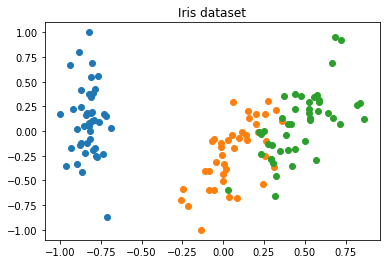

In [5]:
# view the data set as scatter plot to have an idea of the distribution
train_features, train_labels, test_features, test_labels = iris(
    training_size=80,
    test_size=20,
    n=3,
    plot_data=True, one_hot=False)

Here we have used **ZZFeatureMap** which is basicaly Second-order Pauli-Z evolution circuit.

With following ***Arguments:***
- ***feature_dimensions:*** dimensionality of the classical data (equal to the number of required qubits)
- ***reps:*** number of times the feature map circuit is repeated
- ***data_map_function:*** function encoding the classical data.
- ***entanglement:*** generates connectivity 'full' or 'linear' or defining your own entanglement structure

In the following section 
- The outer loop will run two times each for dimensions n={2,3} 
- Then there are two subsections for two methods of QSVM algorithm namely Kernel function & Precomputed Kernel
- With each approach repeated for max_reps number of times currently set to 5.
- The output will capture the score for each combination of parameters 
- Having the backend set to qasm_simulator iterating over 1024 shots each time

In [5]:
# define backend, in this case we have used the qasm_simulator
iris_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,seed_simulator=seed, seed_transpiler=seed)

# Maximum number of reps to use
max_reps = 5

# For loop to use the two dimensions n={2,3} one by one
for dimensions in range(2,4):

    train_features, train_labels, test_features, test_labels = iris(
        training_size=80,
        test_size=20,
        n=dimensions, # dimensions value coming from for loop above for range 2-4 i.e. values 2,3
        plot_data=False, one_hot=False)

    ########## Kernel Function Method
    print('\nKernel function method: Dimensions = ',dimensions)
    # For loop to Iterate over reps from 1 to max_reps    
    for i in range(max_reps):

        nreps = i+1 # index range from 0-4 , here we make it 1-5

        # create the feature map using ZZFeatureMap
        iris_feature_map = ZZFeatureMap(feature_dimension=dimensions, reps=nreps, entanglement='full')

        # define the kernel
        iris_kernel = QuantumKernel(feature_map=iris_feature_map, quantum_instance=iris_backend)
        
        # use the encapsulated Qiskit function QSVC
        iris_qsvc = QSVC(quantum_kernel=iris_kernel)

        # fit the data
        iris_qsvc.fit(train_features, train_labels)

        # score of the test data
        iris_score = iris_qsvc.score(test_features, test_labels)
        print('Reps = ',nreps,' Score = ',iris_score)

        
    ########## Precomputed Kernel Matrices Method
    print('\nPrecomputed kernel method: Dimensions = ',dimensions)
    # For loop to Iterate over reps from 1 to max_reps   
    for i in range(max_reps):

        nreps = i+1 # index range from 0-4 , here we make it 1-5

        # create the feature map using ZZFeatureMap
        iris_feature_map = ZZFeatureMap(feature_dimension=dimensions, reps=nreps, entanglement='full')

        # define the kernel
        iris_kernel = QuantumKernel(feature_map=iris_feature_map, quantum_instance=iris_backend)
        
        #Precomputed matrices
        iris_matrix_train = iris_kernel.evaluate(x_vec=train_features)
        iris_matrix_test = iris_kernel.evaluate(x_vec=test_features, y_vec=train_features)

        iris_qsvc_pre = SVC(kernel='precomputed')
        iris_qsvc_pre.fit(iris_matrix_train, train_labels)
        
        iris_score_pre = iris_qsvc_pre.score(iris_matrix_test, test_labels)
        print('Reps = ',nreps,' Score = ', iris_score_pre)


Kernel function method: Dimensions =  2
Reps =  1  Score =  0.95
Reps =  2  Score =  0.85
Reps =  3  Score =  0.75
Reps =  4  Score =  0.65
Reps =  5  Score =  0.7

Precomputed kernel method: Dimensions =  2
Reps =  1  Score =  0.95
Reps =  2  Score =  0.85
Reps =  3  Score =  0.75
Reps =  4  Score =  0.65
Reps =  5  Score =  0.7

Kernel function method: Dimensions =  3
Reps =  1  Score =  0.8
Reps =  2  Score =  0.6
Reps =  3  Score =  0.6
Reps =  4  Score =  0.7
Reps =  5  Score =  0.6

Precomputed kernel method: Dimensions =  3
Reps =  1  Score =  0.8
Reps =  2  Score =  0.6
Reps =  3  Score =  0.6
Reps =  4  Score =  0.7
Reps =  5  Score =  0.6


**Q1. What is the best score you have obtained?**
<div class="alert alert-block alert-success">
    <b>Ans:</b> The Best score obtained is with 1 Reps & 2 Dimensions for both the Kernel Function and Precomputed Kernel methods
</div>

**Q2. What kind of kernel process fits better: kernel function or precomputed?**
<div class="alert alert-block alert-success">
    <b>Ans:</b> Here both the approaches i.e. Kernel function and precomputed kernel give almost same results given the small amount of data. By pre-computing your kernel, enables you to be able to use different type of kernel functions..but since we are using SVC which is almost same in approach as QSVC we get mostly similar results
</div>


**Q3. What is the input parameter that gives you the best accuracy?**
<div class="alert alert-block alert-success">
    <b>Ans:</b> The best accuracy is obtained when we have reps = 1 and dimensions = 2 and it decreases by increasing number of reps and dimensions
</div>

**Q4. Why your best accuracy is with kernel function/precomputed kernel matrix, x reps and dimension n? Explain your results related to: kernel process, reps input and dimension.**
<div class="alert alert-block alert-success">
    <b>Ans:</b> 

- **Comparing between Kernel function & Precomputed approaches** we don't see much difference in results, this could be due to the fact that same classical approach is used from the SQVC code as used in classical SVC and as mentioned (*There is no proof yet that the QSVM brings a quantum advantage, but the argument the authors of [1](https://arxiv.org/pdf/1804.11326.pdf) make, is that there is for sure no advantage if we use feature maps that are easy to simulate classically, because then we would not need a quantum computer to construct the Kernel.*) 
    
- We also see see that **increasing repetitions** seems to reduce the score this could be because it might induce confusion between the different observation classes. Somehow, it scrambles the information within the rotations making them unrelated and thus reducing the accuracy.
    
- We also see that the score reduces a little bit when we **increase the number of dimensions** this again could depend upon the distribution of data and the kind of correlation of the data between the dimensions for which pssibly a more indepth analysis with feature engineering could be the approach in a more substantial data sets with higher dimensions. 
</div>

**References:**
- https://moodle.upm.es/titulaciones/propias/mod/resource/view.php?id=130794
- https://arxiv.org/pdf/1307.0471.pdf
- https://medium.com/@patrick.huembeli/introduction-into-quantum-support-vector-machines-727f3ccfa2b4
- https://qiskit.org/documentation/stable/0.24/tutorials/machine_learning/01_qsvm_classification.html